In [28]:
import pywt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim

## Peak Signal-to-Noise Ratio (PSNR)

In [29]:
def PSNR(im1_path, im2_path):
    imageA = cv2.imread(im1_path)
    imageB = cv2.imread(im2_path)
    
    imageA = np.clip(np.array(imageA), 0, 255)
    imageB = np.clip(np.array(imageB), 0, 255)

    mse = np.mean((imageA - imageB) ** 2)
    
    if mse == 0:  
        return float('inf')
    
    max_pixel = 255.0 
    psnr_val = 20 * np.log10(max_pixel / np.sqrt(mse))
    
    return psnr_val

## Structural Similarity Index (SSIM)

In [30]:
def ssim(im1_path, im2_path):
    imageA = cv2.imread(im1_path)
    imageB = cv2.imread(im2_path)

    original_gray = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

    ssim_ = compare_ssim(original_gray, compressed_gray)

    return ssim_

## Split image to RGB

In [31]:
def split_rgb(path):
    image = cv2.imread(path) 
    b,g,r = cv2.split(image) 
    return b,g,r

## Merge Image

In [32]:
def save_im(path_sav,rgb):
    merged_image = cv2.merge(rgb)
    cv2.imwrite(path_sav, merged_image)
    return

In [33]:
def labels(im,wav,n):
    coeffs = pywt.wavedec2(im, wavelet=wav, level=n)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return coeff_arr, coeff_slices

## Discrete Wavelet Transform

In [34]:
def DWT_new(image,wav,level,keep,path_coeff,path_binary_im):
    # Perform quantization and select threshold
    coeffs = pywt.wavedec2(image , wavelet=wav, level=level)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)

    Csort = np.sort(np.abs(coeff_arr.reshape(-1)))
    thresh = Csort[int(np.floor((1 - keep) * len(Csort)))]
    ind = np.abs(coeff_arr) > thresh
    Cfilt = coeff_arr * ind
    
    coeff_wav = []
    index = []
    matrix = np.zeros((Cfilt.shape[0],Cfilt.shape[1]), dtype=np.uint8)
    count = 0

    # Loop through the quantization coefficients after selecting the threshold and keep only non-zero coefficients 
    for i in range(Cfilt.shape[0]):
        for j in range(Cfilt.shape[1]):
            if Cfilt[i][j] != 0:
                coeff_wav.append(round(Cfilt[i][j],0))
                # Save the index of the non-zero coefficient position
                index.append(count)
            count+=1
            


  

    # Save non-zero coefficients
    coeff_wav = np.array(coeff_wav)
    np.save(path_coeff,coeff_wav)

    # Convert index to label image file in binary image format
    matrix[np.unravel_index(index, (Cfilt.shape[0],Cfilt.shape[1]))] = 1
    image = Image.fromarray(matrix * 255)
    image.save(path_binary_im)
    return 

## Decompression

In [35]:
def de_DWT_new(path_coeff,path_binary_im,Cfilt,coeff_slices,wav):
    # Load file codebook and Label
    coeff_wav_load = np.load(path_coeff)
    image = Image.open(path_binary_im)  
    image_array = np.array(image)

    match_im = np.zeros((Cfilt.shape[0],Cfilt.shape[1]), dtype=float)

    count = 0
    # Loop through the loop to reconstruct the quantized image
    for i in range(image_array.shape[0]):
        for j in range(image_array.shape[1]):
            if image_array[i][j] != 0:
                match_im[i][j] = coeff_wav_load[count]
                count+=1
    coeffs_filt = pywt.array_to_coeffs(match_im, coeff_slices, output_format='wavedec2')
    # Regenerate the original image
    Arecon = pywt.waverec2(coeffs_filt, wavelet=wav)
    Arecon = (Arecon - np.min(Arecon)) / (np.max(Arecon) - np.min(Arecon)) * 255
    return Arecon

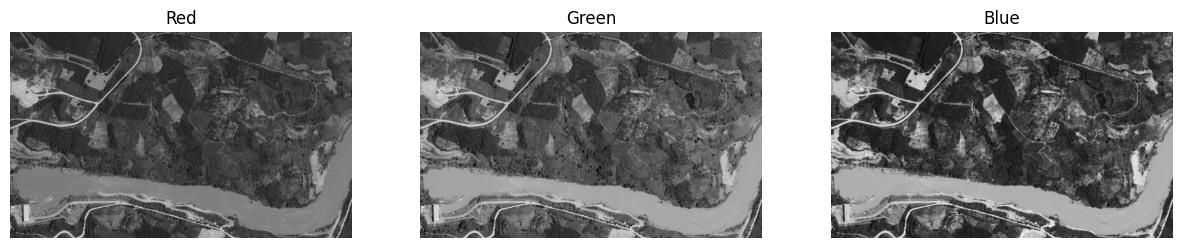

In [36]:
path = "satellite_image.png"
rgb = ['Red','Green','Blue']

RGB_image = split_rgb(path)

plt.figure(figsize=(15,9))

for i in range(len(RGB_image)):
    plt.subplot(1, 3, i+1)
    plt.axis('off')
    plt.title(rgb[i])
    plt.imshow(RGB_image[i],'gray')

In [37]:
wav = 'db4'
keep = 0.05
lev = 3

In [38]:
for i in range(len(RGB_image)):
    path_coeff = f'coeff_{rgb[i]}.npy'
    path_binary_im = f'binary_im_{rgb[i]}.png'
    DWT_new(RGB_image[i],wav,lev,keep,path_coeff,path_binary_im)

In [39]:
rgb_decompression = []

In [40]:
for i in range(len(RGB_image)):
    path_coeff = f'coeff_{rgb[i]}.npy'
    path_binary_im = f'binary_im_{rgb[i]}.png'
    
    Cfilt,coeff_slices = labels(RGB_image[i],wav,lev)

    rgb_decompression.append(de_DWT_new(path_coeff,path_binary_im,Cfilt,coeff_slices,wav))

save_im('decompression_image.png',rgb_decompression)

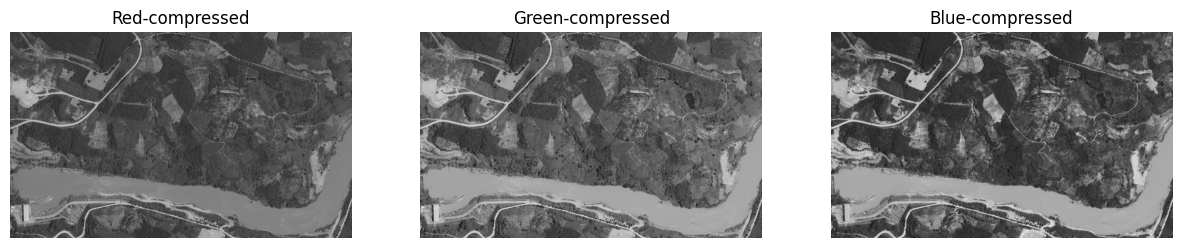

In [41]:
plt.figure(figsize=(15,9))

for i in range(len(RGB_image)):
    plt.subplot(1, 3, i+1)
    plt.axis('off')
    plt.title(f'{rgb[i]}-compressed')
    plt.imshow(rgb_decompression[i],'gray')

In [42]:
psnr = PSNR('decompression_image.png',"satellite_image.png")
ssim_ = ssim('decompression_image.png',"satellite_image.png")

print(f"PSNR : {psnr}")
print(f"SSIM : {ssim_}")

PSNR : 29.574974444821635
SSIM : 0.7271495852092889
